# Backward Feature Selection

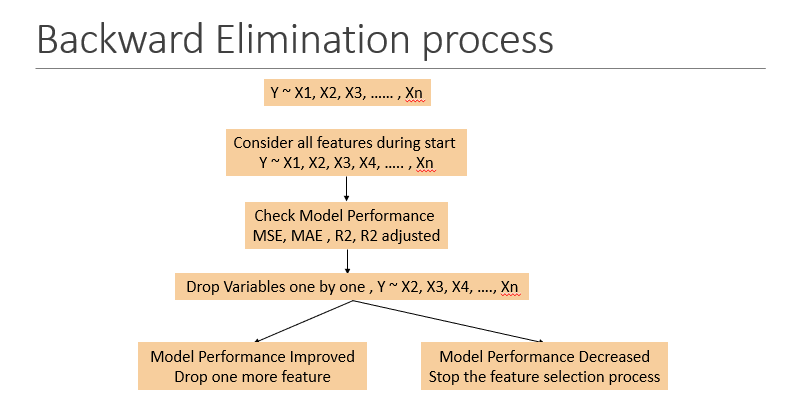

In [1]:
from warnings import filterwarnings

filterwarnings("ignore")

# Step 1 - Data ingestion

In [2]:
import pandas as pd

df = pd.read_csv("Cars93.csv", na_values=["", "NA"], keep_default_na=False)
df.head()

,id,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,...,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin,Make
0,1,Acura,Integra,Small,12.9,15.9,18.8,25,31,None,...,5,177,102,68,37,26.5,11.0,2705,non-USA,Acura Integra
1,2,Acura,Legend,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,...,5,195,115,71,38,30.0,15.0,3560,non-USA,Acura Legend
2,3,Audi,90,Compact,25.9,29.1,32.3,20,26,Driver only,...,5,180,102,67,37,28.0,14.0,3375,non-USA,Audi 90
3,4,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,...,6,193,106,70,37,31.0,17.0,3405,non-USA,Audi 100
4,5,BMW,535i,Midsize,23.7,30.0,36.2,22,30,Driver only,...,4,186,109,69,39,27.0,13.0,3640,non-USA,BMW 535i


# Target - Weight 
Predict weight of cars based on other factors

# Step 2 - Perform basic data quality checks

In [3]:
df.shape

(94, 28)

In [4]:
df.duplicated().sum()

np.int64(1)

In [5]:
df = df.drop_duplicates(keep="first").reset_index(drop=True)
df.shape

(93, 28)

In [6]:
m = df.isna().sum()
m[m > 0]

AirBags            4
Rear.seat.room     2
Luggage.room      11
dtype: int64

In [7]:
# Cardinality is checked only on categorical features
df.select_dtypes(include="object").nunique()

Manufacturer       32
Model              93
Type                6
AirBags             3
DriveTrain          3
Cylinders           6
Man.trans.avail     2
Origin              2
Make               93
dtype: int64

In [8]:
len(df)

93

In [9]:
def get_high_card(df, threshold=0.9):
    cat_unique = df.select_dtypes(include="object").nunique()
    rows = len(df)
    cardinality = cat_unique / rows
    high_card = cardinality[cardinality >= threshold]
    print(high_card)
    return high_card.index.tolist()

In [10]:
high_card = get_high_card(df, threshold=0.9)
print(high_card)

Model    1.0
Make     1.0
dtype: float64
['Model', 'Make']


In [11]:
df = df.drop(columns=high_card)
df.shape

(93, 26)

In [12]:
df.head()

,id,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin
0,1,Acura,Small,12.9,15.9,18.8,25,31,None,Front,...,13.2,5,177,102,68,37,26.5,11.0,2705,non-USA
1,2,Acura,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,...,18.0,5,195,115,71,38,30.0,15.0,3560,non-USA
2,3,Audi,Compact,25.9,29.1,32.3,20,26,Driver only,Front,...,16.9,5,180,102,67,37,28.0,14.0,3375,non-USA
3,4,Audi,Midsize,30.8,37.7,44.6,19,26,NaN,Front,...,21.1,6,193,106,70,37,31.0,17.0,3405,non-USA
4,5,BMW,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,...,21.1,4,186,109,69,39,27.0,13.0,3640,non-USA


# Step 3 - Seperate X and Y(Weight)

In [13]:
X = df.drop(columns=["id", "Weight"])
Y = df["Weight"]

In [14]:
X.head()

,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,...,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin
0,Acura,Small,12.9,15.9,18.8,25,31,None,Front,4,...,Yes,13.2,5,177,102,68,37,26.5,11.0,non-USA
1,Acura,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,6,...,Yes,18.0,5,195,115,71,38,30.0,15.0,non-USA
2,Audi,Compact,25.9,29.1,32.3,20,26,Driver only,Front,6,...,Yes,16.9,5,180,102,67,37,28.0,14.0,non-USA
3,Audi,Midsize,30.8,37.7,44.6,19,26,NaN,Front,6,...,Yes,21.1,6,193,106,70,37,31.0,17.0,non-USA
4,BMW,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,4,...,Yes,21.1,4,186,109,69,39,27.0,13.0,non-USA


In [15]:
Y.head()

0    2705
1    3560
2    3375
3    3405
4    3640
Name: Weight, dtype: int64

# Step 4 - Train Test Split
test 0.2-0.4

In [16]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=10)

In [17]:
xtrain.head()

,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,...,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin
42,Honda,Compact,13.8,17.5,21.2,24,31,Driver & Passenger,Front,4,...,Yes,17.0,4,185,107,67,41,28.0,14.0,non-USA
53,Mazda,Small,10.9,11.6,12.3,28,36,None,Front,4,...,Yes,14.5,5,172,98,66,36,26.5,13.0,non-USA
21,Chrysler,Large,29.5,29.5,29.5,20,26,NaN,Front,6,...,No,16.0,6,203,110,69,44,36.0,17.0,USA
6,Buick,Large,19.9,20.8,21.7,19,28,Driver only,Front,6,...,No,18.0,6,200,111,74,42,30.5,17.0,USA
26,Dodge,Midsize,14.8,15.6,16.4,21,27,Driver only,Front,4,...,No,16.0,6,192,105,69,42,30.5,16.0,USA


In [18]:
ytrain.head()

42    3040
53    2440
21    3570
6     3470
26    3080
Name: Weight, dtype: int64

In [19]:
xtest.head()

,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,...,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin
34,Ford,Sporty,12.8,14.0,15.2,24,30,Driver only,Front,4,...,Yes,15.5,4,179,103,70,38,23.0,18.0,USA
90,Volkswagen,Sporty,22.9,23.3,23.7,18,25,None,Front,6,...,Yes,18.5,4,159,97,66,36,26.0,15.0,non-USA
3,Audi,Midsize,30.8,37.7,44.6,19,26,NaN,Front,6,...,Yes,21.1,6,193,106,70,37,31.0,17.0,non-USA
35,Ford,Van,14.5,19.9,25.3,15,20,Driver only,4WD,6,...,Yes,21.0,7,176,119,72,45,30.0,NaN,USA
19,Chrylser,Large,18.4,18.4,18.4,20,28,Driver & Passenger,Front,6,...,No,18.0,6,203,113,74,40,31.0,15.0,USA


In [20]:
ytest.head()

34    2710
90    2810
3     3405
35    3735
19    3515
Name: Weight, dtype: int64

# Step 5 - Apply Preprocessing on xtrain, xtest

In [21]:
cat_cols = X.select_dtypes(include="object").columns.tolist()
cat_cols

['Manufacturer',
 'Type',
 'AirBags',
 'DriveTrain',
 'Cylinders',
 'Man.trans.avail',
 'Origin']

In [22]:
num_cols = X.select_dtypes(include="number").columns.tolist()
num_cols

['Min.Price',
 'Price',
 'Max.Price',
 'MPG.city',
 'MPG.highway',
 'EngineSize',
 'Horsepower',
 'RPM',
 'Rev.per.mile',
 'Fuel.tank.capacity',
 'Passengers',
 'Length',
 'Wheelbase',
 'Width',
 'Turn.circle',
 'Rear.seat.room',
 'Luggage.room']

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [24]:
num_pipe = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [25]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    StandardScaler(),
)

In [26]:
pre = ColumnTransformer(
    [("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)]
).set_output(transform="pandas")

In [27]:
pre.fit(xtrain)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [28]:
xtrain_pre = pre.transform(xtrain)
xtrain_pre.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,num__Turn.circle,num__Rear.seat.room,num__Luggage.room,cat__Manufacturer,cat__Type,cat__AirBags,cat__DriveTrain,cat__Cylinders,cat__Man.trans.avail,cat__Origin
42,-0.373824,-0.208643,-0.071922,0.318308,0.363084,-0.499737,-0.070927,0.583333,0.553885,0.094849,...,0.554316,0.030727,0.028068,-0.330948,-1.373237,-1.720536,-0.180439,-0.763650,0.780189,1.114641
53,-0.699007,-0.802086,-0.851002,1.066078,1.322665,-0.871400,-0.759572,0.416667,-0.190474,-0.664766,...,-0.987766,-0.456514,-0.318105,0.266373,0.474391,1.173093,-0.180439,-0.763650,0.780189,1.114641
21,1.386650,0.998360,0.654635,-0.429463,-0.596496,0.522338,0.059357,-0.750000,-1.020721,-0.208997,...,1.479565,2.629344,1.066586,-0.928269,-0.757361,-0.273722,-0.180439,0.975122,-1.281740,-0.897150
6,0.310182,0.123283,-0.028154,-0.616405,-0.212664,0.986917,0.487434,-0.750000,-1.431073,0.398695,...,0.862732,0.842795,1.066586,-1.286661,-0.757361,-0.273722,-0.180439,0.975122,-1.281740,-0.897150
26,-0.261692,-0.399752,-0.492100,-0.242520,-0.404580,-0.220989,-0.815408,-0.750000,0.277136,-0.208997,...,0.862732,0.842795,0.720413,-0.808804,-0.141485,-0.273722,-0.180439,-0.763650,-1.281740,-0.897150


In [29]:
xtest_pre = pre.transform(xtest)
xtest_pre.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,num__Turn.circle,num__Rear.seat.room,num__Luggage.room,cat__Manufacturer,cat__Type,cat__AirBags,cat__DriveTrain,cat__Cylinders,cat__Man.trans.avail,cat__Origin
34,-0.485956,-0.560685,-0.597145,0.318308,0.171168,-0.685568,-0.536227,0.416667,0.038559,-0.360920,...,-0.370933,-1.593409,1.412758,-0.569876,1.090267,-0.273722,-0.180439,-0.763650,0.780189,-0.897150
90,0.646578,0.374742,0.146920,-0.803348,-0.788412,0.057759,0.636330,0.916667,0.124447,0.550618,...,-0.987766,-0.618927,0.374241,1.699942,1.090267,1.173093,-0.180439,0.975122,0.780189,1.114641
3,1.532421,1.823145,1.976445,-0.616405,-0.596496,0.057759,0.524658,0.416667,0.410739,1.340618,...,-0.679350,1.005208,1.066586,-1.525589,-0.141485,-0.273722,-0.180439,0.975122,0.780189,1.114641
35,-0.295332,0.032758,0.286980,-1.364176,-1.747992,0.243590,0.022133,-0.750000,-0.457680,1.310233,...,1.787981,0.680381,0.028068,-0.569876,1.706143,-0.273722,-2.087934,0.975122,0.780189,-0.897150
19,0.141983,-0.118118,-0.317026,-0.429463,-0.212664,0.522338,0.171029,0.083333,-0.629455,0.398695,...,0.245900,1.005208,0.374241,-1.764517,-0.757361,-1.720536,-0.180439,0.975122,-1.281740,-0.897150


# Step 6 - Check base model performance

In [30]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(xtrain_pre, ytrain)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [31]:
train_r2 = model.score(xtrain_pre, ytrain)
print(f"Train R2 : {train_r2:.4f}")

Train R2 : 0.9725


In [32]:
test_r2 = model.score(xtest_pre, ytest)
print(f"Test R2 : {test_r2:.4f}")

Test R2 : 0.8217


In [33]:
gen_error = abs(train_r2 - test_r2)
print(f"Generalization Error : {gen_error:.4f}")

Generalization Error : 0.1508


# Step 7 - Forward Feature selection
one by one features are added in model

In [34]:
from sklearn.feature_selection import SequentialFeatureSelector

base_model = LinearRegression()
sel = SequentialFeatureSelector(
    base_model,
    n_features_to_select="auto",
    direction="backward",  # change direction here
).set_output(transform="pandas")
sel.fit(xtrain_pre, ytrain)

,estimator,LinearRegression()
,n_features_to_select,'auto'
,tol,None
,direction,'backward'
,scoring,None
,cv,5
,n_jobs,None
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [35]:
sel_cols = sel.get_feature_names_out()
print(sel_cols)

['num__Min.Price' 'num__Price' 'num__MPG.highway' 'num__EngineSize'
 'num__Horsepower' 'num__RPM' 'num__Rev.per.mile'
 'num__Fuel.tank.capacity' 'num__Length' 'num__Wheelbase' 'cat__Type'
 'cat__Origin']


In [36]:
len(sel_cols)

12

In [37]:
xtrain_pre_sel = sel.transform(xtrain_pre)
xtrain_pre_sel.head()

,num__Min.Price,num__Price,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,num__Length,num__Wheelbase,cat__Type,cat__Origin
42,-0.373824,-0.208643,0.363084,-0.499737,-0.070927,0.583333,0.553885,0.094849,0.075537,0.450415,-1.373237,1.114641
53,-0.699007,-0.802086,1.322665,-0.871400,-0.759572,0.416667,-0.190474,-0.664766,-0.832796,-0.913114,0.474391,1.114641
21,1.386650,0.998360,-0.596496,0.522338,0.059357,-0.750000,-1.020721,-0.208997,1.333229,0.904925,-0.757361,-0.897150
6,0.310182,0.123283,-0.212664,0.986917,0.487434,-0.750000,-1.431073,0.398695,1.123614,1.056428,-0.757361,-0.897150
26,-0.261692,-0.399752,-0.404580,-0.220989,-0.815408,-0.750000,0.277136,-0.208997,0.564640,0.147409,-0.141485,-0.897150


In [38]:
xtest_pre_sel = sel.transform(xtest_pre)
xtest_pre_sel.head()

,num__Min.Price,num__Price,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,num__Length,num__Wheelbase,cat__Type,cat__Origin
34,-0.485956,-0.560685,0.171168,-0.685568,-0.536227,0.416667,0.038559,-0.360920,-0.343694,-0.155598,1.090267,-0.897150
90,0.646578,0.374742,-0.788412,0.057759,0.636330,0.916667,0.124447,0.550618,-1.741130,-1.064618,1.090267,1.114641
3,1.532421,1.823145,-0.596496,0.057759,0.524658,0.416667,0.410739,1.340618,0.634511,0.298912,-0.141485,1.114641
35,-0.295332,0.032758,-1.747992,0.243590,0.022133,-0.750000,-0.457680,1.310233,-0.553309,2.268454,1.706143,-0.897150
19,0.141983,-0.118118,-0.212664,0.522338,0.171029,0.083333,-0.629455,0.398695,1.333229,1.359435,-0.757361,-0.897150


# Step 8 - Fit and Evalute the feature selected model

In [39]:
model_sel = LinearRegression()
model_sel.fit(xtrain_pre_sel, ytrain)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [40]:
r2_train_sel = model_sel.score(xtrain_pre_sel, ytrain)
print(f"R2 train on selected features : {r2_train_sel:.4f}")

R2 train on selected features : 0.9692


In [41]:
r2_test_sel = model_sel.score(xtest_pre_sel, ytest)
print(f"R2 test on selected features : {r2_test_sel:.4f}")

R2 test on selected features : 0.8406


In [42]:
gen_err_sel = abs(r2_train_sel - r2_test_sel)
print(f"Generalization Error on Selected features : {gen_err_sel:.4f}")

Generalization Error on Selected features : 0.1286


# Step 9 - Evalute model in detail

In [43]:
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)


def evaluate_model(model, x, y):
    ypred = model.predict(x)
    rmse = root_mean_squared_error(y, ypred)
    mae = mean_absolute_error(y, ypred)
    mape = mean_absolute_percentage_error(y, ypred)
    r2 = r2_score(y, ypred)
    print(f"RMSE : {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"MAPE : {mape:.2%}")
    print(f"R2 : {r2:.2%}")

In [44]:
print("Training Results : ")
evaluate_model(model_sel, xtrain_pre_sel, ytrain)

Training Results : 
RMSE : 107.04
MAE : 88.49
MAPE : 2.98%
R2 : 96.92%


In [45]:
print("Testing Results : ")
evaluate_model(model_sel, xtest_pre_sel, ytest)

Testing Results : 
RMSE : 192.42
MAE : 144.06
MAPE : 4.86%
R2 : 84.06%


# Step 10 - Perform out of sample prediction

In [46]:
xnew = pd.read_csv("sample.csv")
xnew

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin,Make
0,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,...,15.0,6,190,106,65,37,31.0,17.0,non-USA,Audi 100
1,Pontiac,Sunbird,Compact,9.4,11.1,12.8,23,31,NaN,Front,...,15.2,5,181,101,66,39,25.0,13.0,USA,Pontiac Sunbird
2,Chevrolet,Lumina,Midsize,13.4,15.9,18.4,21,29,NaN,Front,...,16.5,6,198,108,71,40,28.5,16.0,USA,Chevrolet Lumina
3,Mazda,RX-7,Sporty,32.5,32.5,32.5,17,25,Driver only,Rear,...,20.0,2,169,96,69,37,NaN,NaN,non-USA,Mazda RX-7
4,Volkswagen,Fox,Small,8.7,9.1,9.5,25,33,NaN,Front,...,12.4,4,163,93,63,34,26.0,10.0,non-USA,Volkswagen Fox


In [47]:
xnew_pre = pre.transform(xnew)
xnew_pre

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,num__Turn.circle,num__Rear.seat.room,num__Luggage.room,cat__Manufacturer,cat__Type,cat__AirBags,cat__DriveTrain,cat__Cylinders,cat__Man.trans.avail,cat__Origin
0,1.532421,1.823145,1.976445,-0.616405,-0.596496,0.057759,0.524658,0.416667,0.410739,-0.512843,...,-0.679350,1.005208,1.066586,-1.525589,-0.141485,-0.273722,-0.180439,0.975122,0.780189,1.114641
1,-0.867205,-0.852378,-0.807234,0.131365,0.363084,-0.685568,-0.629288,-0.083333,0.658858,-0.452074,...,-0.062517,-0.943754,-0.318105,0.983157,-1.373237,-0.273722,-0.180439,-0.763650,0.780189,-0.897150
2,-0.418677,-0.369577,-0.317026,-0.242520,-0.020748,-0.499737,-0.629288,-0.083333,0.525255,-0.057074,...,0.245900,0.193140,0.720413,-1.047733,-0.141485,-0.273722,-0.180439,-0.763650,-1.281740,-0.897150
3,1.723046,1.300111,0.917246,-0.990291,-0.788412,-1.335979,2.069456,2.083333,0.009930,1.006387,...,-0.679350,-0.131687,0.028068,0.266373,1.090267,-0.273722,1.727057,-2.502421,0.780189,1.114641
4,-0.945698,-1.053545,-1.096106,0.505250,0.746917,-0.871400,-1.169036,0.416667,0.439368,-1.302842,...,-1.604599,-0.618927,-1.356622,1.699942,0.474391,-0.273722,-0.180439,-0.763650,0.780189,1.114641


In [48]:
xnew_pre_sel = sel.transform(xnew_pre)
xnew_pre_sel

,num__Min.Price,num__Price,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,num__Length,num__Wheelbase,cat__Type,cat__Origin
0,1.532421,1.823145,-0.596496,0.057759,0.524658,0.416667,0.410739,-0.512843,0.424896,0.298912,-0.141485,1.114641
1,-0.867205,-0.852378,0.363084,-0.685568,-0.629288,-0.083333,0.658858,-0.452074,-0.203950,-0.458604,-1.373237,-0.897150
2,-0.418677,-0.369577,-0.020748,-0.499737,-0.629288,-0.083333,0.525255,-0.057074,0.983870,0.601918,-0.141485,-0.897150
3,1.723046,1.300111,-0.788412,-1.335979,2.069456,2.083333,0.009930,1.006387,-1.042412,-1.216121,1.090267,1.114641
4,-0.945698,-1.053545,0.746917,-0.871400,-1.169036,0.416667,0.439368,-1.302842,-1.461642,-1.670631,0.474391,1.114641


In [49]:
preds = model_sel.predict(xnew_pre_sel)
preds

array([3255.60214796, 2700.74236997, 3132.76680149, 3469.66709788,
       2222.19057096])

In [50]:
xnew["Weight"] = preds.round(2)
xnew

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin,Make,Weight
0,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,...,6,190,106,65,37,31.0,17.0,non-USA,Audi 100,3255.60
1,Pontiac,Sunbird,Compact,9.4,11.1,12.8,23,31,NaN,Front,...,5,181,101,66,39,25.0,13.0,USA,Pontiac Sunbird,2700.74
2,Chevrolet,Lumina,Midsize,13.4,15.9,18.4,21,29,NaN,Front,...,6,198,108,71,40,28.5,16.0,USA,Chevrolet Lumina,3132.77
3,Mazda,RX-7,Sporty,32.5,32.5,32.5,17,25,Driver only,Rear,...,2,169,96,69,37,NaN,NaN,non-USA,Mazda RX-7,3469.67
4,Volkswagen,Fox,Small,8.7,9.1,9.5,25,33,NaN,Front,...,4,163,93,63,34,26.0,10.0,non-USA,Volkswagen Fox,2222.19


In [51]:
xnew.to_csv("backward_results.csv", index=False)

# Save the model object and sel and pre

In [52]:
pre

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [53]:
sel

,estimator,LinearRegression()
,n_features_to_select,'auto'
,tol,None
,direction,'backward'
,scoring,None
,cv,5
,n_jobs,None
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [54]:
model_sel

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [55]:
import joblib

joblib.dump(pre, "backward_pre.joblib")

['backward_pre.joblib']

In [56]:
joblib.dump(sel, "backward_sel.joblib")

['backward_sel.joblib']

In [57]:
joblib.dump(model_sel, "backward_model.joblib")

['backward_model.joblib']

In [58]:
p = joblib.load("backward_pre.joblib")
p

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [59]:
s = joblib.load("backward_sel.joblib")
s

,estimator,LinearRegression()
,n_features_to_select,'auto'
,tol,None
,direction,'backward'
,scoring,None
,cv,5
,n_jobs,None
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [60]:
m = joblib.load("backward_model.joblib")
m

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [61]:
m.score(xtrain_pre_sel, ytrain)

0.9691945897890565

In [62]:
m.score(xtest_pre_sel, ytest)

0.84063876863847